# Comparison of DYAMOND models

## Preparations

### Import Packages

In [3]:
#%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import typhon
import cartopy.crs as ccrs
import processing_tools
import seaborn as sns
import analysis_tools as atools
from modeldata import Modeldata, VariableField
from netCDF4 import Dataset
from os.path import join
%matplotlib inline 

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


### Configuration

In [4]:
# Models and variables
models = ['ICON', 'NICAM', 'GEOS', 'IFS', 'SAM']
runs = {
    'ICON': '5.0km_2',
    'NICAM': '3.5km',
    'GEOS': '3.0km',
    'IFS': '4.0km',
    'SAM': '4.0km'
}
hum_variables = ['TEMP', 'PRES', 'QV']
datapaths = {m: f'/mnt/lustre02/work/mh1126/m300773/DYAMOND/{m}' for m in models}

# Plots
plt.rcParams.update({'font.size': 15})

### Read Latitudes, Longitudes and Height Levels

In [5]:
filename = 'ICON-5.0km_2_TEMP_hinterp_timeaverage_vinterp.nc'
lat = atools.read_var(join(datapaths['ICON'], filename), 'lat')
lon = atools.read_var(join(datapaths['ICON'], filename), 'lon')
height = atools.read_var(join(datapaths['ICON'], filename), 'zlev')
dimensions = ['height', 'latitude', 'longitude']
dimensionvars = {
    'height': height,
    'latitude': lat,
    'longitude':lon
}

## Humidity

### Read data

In [25]:
# Read 30-day horizontally and vertically interpolated averages of temperature, specific humidity and pressue
modeldata = dict.fromkeys(models)
global_field = dict.fromkeys(hum_variables)

for m in models:
    for var in hum_variables:
        filename = f'{m}-{runs[m]}_{var}_hinterp_timeaverage_vinterp.nc'
        global_field[var] = atools.read_var(join(datapaths[m], filename), var)
    modeldata[m] = Modeldata(m, dimensions, dimensionvars, global_field)

# specific humidity from SAM is in g/kg
modeldata['SAM'].global_fields['QV'].data = modeldata['SAM'].global_fields['QV'].data * 1e-3

### Calculations

#### Relative humidity

In [26]:
#FIXME: Write RH to netCDF files when all models are ready to save time for calculation here
for m in models:    
    RH = atools.spec_hum2rel_hum(
        modeldata[m].global_fields['QV'].data,
        modeldata[m].global_fields['TEMP'].data,
        modeldata[m].global_fields['PRES'].data,
        phase='mixed'
    )
    modeldata[m].add_global_field(RH, 'RH')

/mnt/lustre02/work/um0878/users/tlang/dev/typhon/typhon/physics/thermodynamics.py:94: RuntimeWarning: invalid value encountered in less_equal
  if np.any(T <= 0):
/mnt/lustre02/work/um0878/users/tlang/dev/typhon/typhon/physics/thermodynamics.py:54: RuntimeWarning: invalid value encountered in less_equal
  if np.any(T <= 0):
/mnt/lustre02/work/um0878/users/tlang/dev/typhon/typhon/physics/thermodynamics.py:172: RuntimeWarning: invalid value encountered in greater
  is_water = T > constants.triple_point_water
/mnt/lustre02/work/um0878/users/tlang/dev/typhon/typhon/physics/thermodynamics.py:174: RuntimeWarning: invalid value encountered in less
  is_ice = T < (constants.triple_point_water - 23.)


#### Areal means

In [27]:
zonal_mean = dict.fromkeys(models)
tropical_field = dict.fromkeys(models)
tropical_mean_profile = dict.fromkeys(models)

for m in models:
    zonal_mean[m] = modeldata[m].get_zonal_means()
    tropical_mean_profile[m] = modeldata[m].get_tropical_mean_profiles()

/mnt/lustre02/work/um0878/users/tlang/work/dyamond/analysis/modeldata.py:126: RuntimeWarning: Mean of empty slice
  np.squeeze(np.nanmean(self.data, axis=average_axis))


#### Select height boxes for pdfs

In [28]:
#FIXME: Hier weiter mit Umstrukturierung!
pdf_heights = [10000]
height_bnds = dict.fromkeys(pdf_heights)
height_bnds = {10000: [8000, 12000]}
lat_bnds = [-30, 30]
lon_bnds = [-180, 180]
tropical_level_rel_hum = {m: dict.fromkeys(pdf_heights) for m in models}
        
for m in models:
    areal_rh = modeldata[m].global_fields['RH'].select_subfield('latitude', lat_bnds).select_subfield('longitude', lon_bnds)
    for h in pdf_heights:
        tropical_level_rel_hum[m][h] = areal_rh.select_subfield('height', height_bnds[h])

### Plots

#### Altitude - pressure 

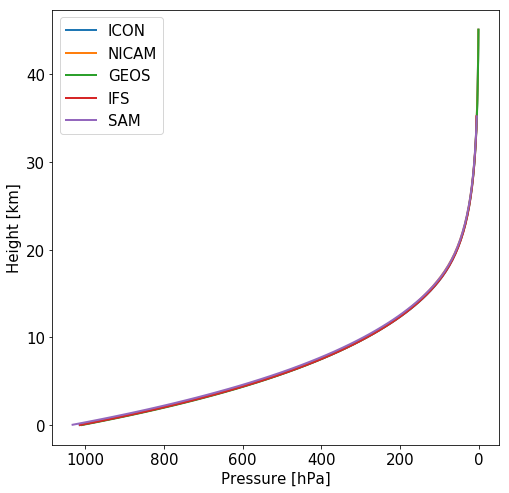

In [29]:
fig, ax = plt.subplots(figsize=(8, 8))

for m in models:
    ax.plot(modeldata[m].tropical_mean_profiles['PRES'].data * 1e-2, height * 1e-3, lw=2, label=m)

ax.set_xlabel('Pressure [hPa]')
ax.set_ylabel('Height [km]')
ax.legend()
ax.invert_xaxis()

#### Zonal mean temperature

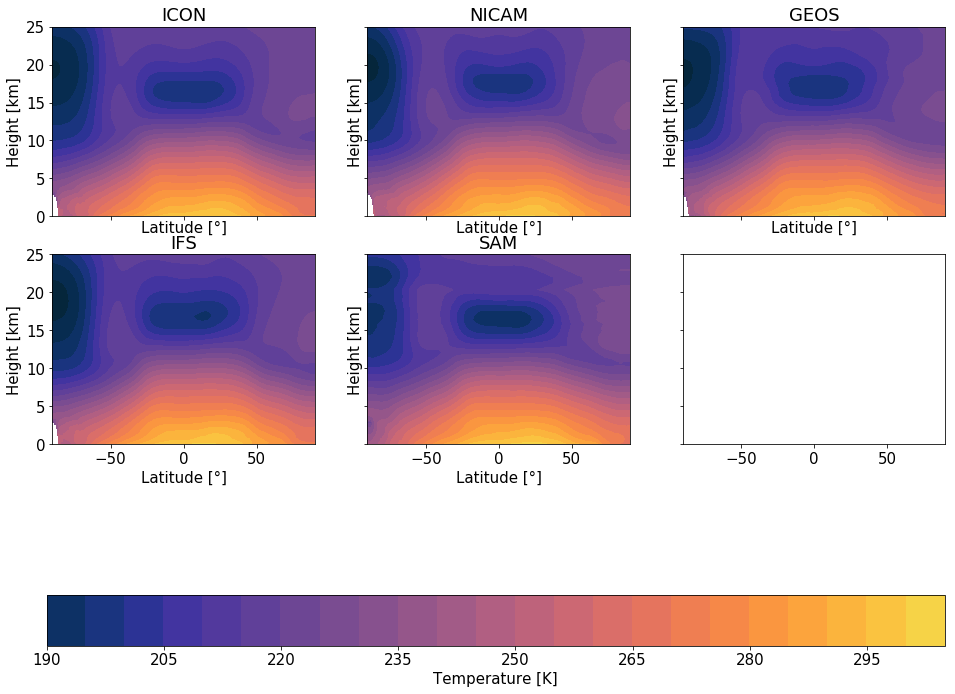

In [35]:
numplots_h = 3
numplots_v = int(np.ceil(len(models) / numplots_h))
la, hi = np.meshgrid(lat, height * 1e-3)
vmin = 180 
vmax = 315

fig, ax = plt.subplots(numplots_v, numplots_h, figsize=(16, 5 * numplots_v), sharex=True, sharey=True)
ax_r = ax.ravel()

for n, m in enumerate(models):
    im = ax_r[n].contourf(la, hi, modeldata[m].zonal_means['TEMP'].data, 23, cmap='temperature', vmin=vmin, vmax=vmax)
    ax_r[n].set_title(m)
    ax_r[n].set_ylabel('Height [km]')
    ax_r[n].set_xlabel('Latitude [°]')


ax_r[0].set_ylim(0, 25)

fig.subplots_adjust(bottom=0.3)
cbar_ax = fig.add_axes([0.12, 0.02, 0.78, 0.07])
cb = fig.colorbar(im, orientation='horizontal', cax=cbar_ax)
cb.set_label('Temperature [K]')

#### Zonal mean specific humidity

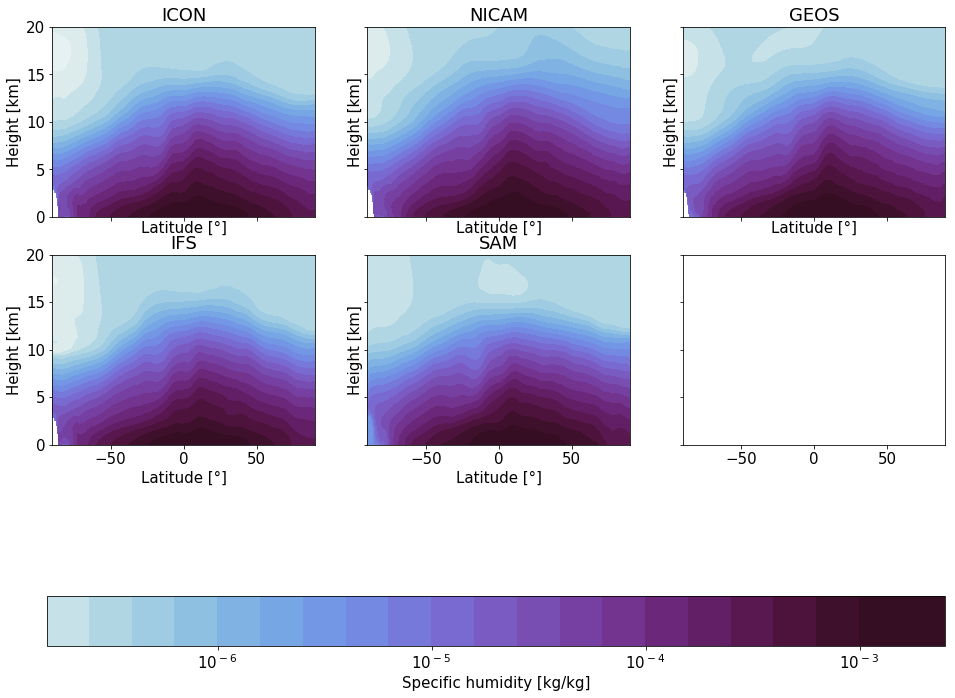

In [31]:
numplots_h = 3
numplots_v = int(np.ceil(len(models) / numplots_h))
la, hi = np.meshgrid(lat, height * 1e-3)
vmin = -6 
vmax = -2
ticks = np.asarray([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
tick_labels = [f'10$^-$$^{i:.0f}$' for i in -np.log10(ticks)]
log_ticks = np.log10(ticks)

fig, ax = plt.subplots(numplots_v, numplots_h, figsize=(16, 5 * numplots_v), sharex=True, sharey=True)
ax_r = ax.ravel()

for n, m in enumerate(models):
    im = ax_r[n].contourf(la, hi, np.log10(modeldata[m].zonal_means['QV'].data), 23, cmap='density', vmin=vmin, vmax=vmax)
    ax_r[n].set_title(m)
    ax_r[n].set_ylabel('Height [km]')
    ax_r[n].set_xlabel('Latitude [°]')


ax_r[0].set_ylim(0, 20)

fig.subplots_adjust(bottom=0.3)
cbar_ax = fig.add_axes([0.12, 0.02, 0.78, 0.07])
cb = fig.colorbar(im, orientation='horizontal', cax=cbar_ax, ticks=log_ticks)
cb.ax.set_xticklabels(tick_labels)
cb.set_label('Specific humidity [kg/kg]')

#### Zonal mean relative humidity

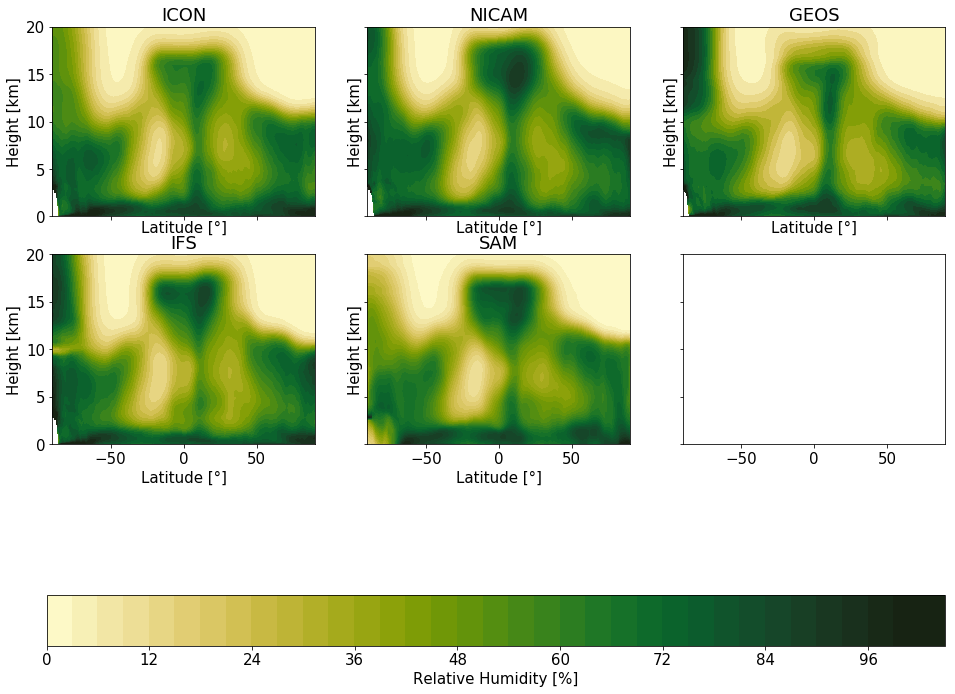

In [32]:
numplots_h = 3
numplots_v = int(np.ceil(len(models) / numplots_h))
la, hi = np.meshgrid(lat, height * 1e-3)
vmin = 0 
vmax = 100

fig, ax = plt.subplots(numplots_v, numplots_h, figsize=(16, 5 * numplots_v), sharex=True, sharey=True)
ax_r = ax.ravel()

for n, m in enumerate(models):
    im = ax_r[n].contourf(la, hi, modeldata[m].zonal_means['RH'].data * 1e2, 35, cmap='speed', vmin=vmin, vmax=vmax)
    ax_r[n].set_title(m)
    ax_r[n].set_ylabel('Height [km]')
    ax_r[n].set_xlabel('Latitude [°]')


ax_r[0].set_ylim(0, 20)
#ax_r[0].set_xlim(-30, 30)
fig.subplots_adjust(bottom=0.3)
cbar_ax = fig.add_axes([0.12, 0.02, 0.78, 0.07])
cb = fig.colorbar(im, orientation='horizontal', cax=cbar_ax)
cb.set_label('Relative Humidity [%]')

#### Tropical mean profiles of Temperature and Humidity

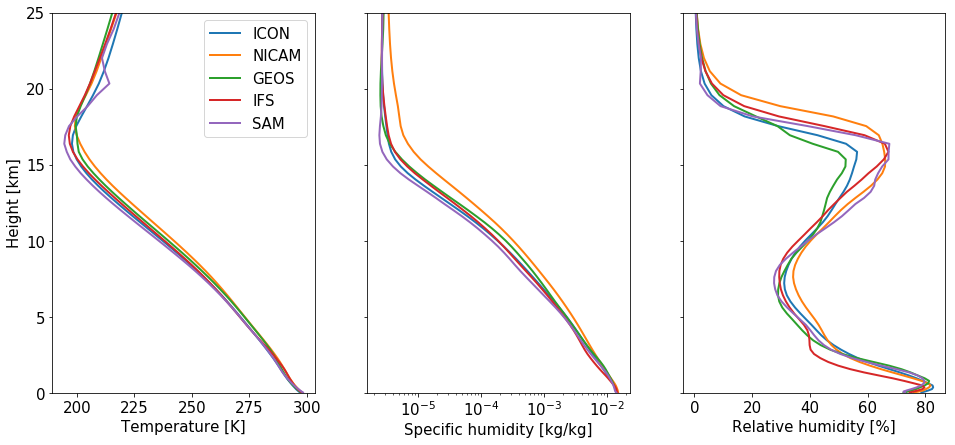

In [33]:
numplots_h = 3
numplots_v = 1

fig, ax = plt.subplots(numplots_v, numplots_h, figsize=(16, 7), sharey=True)
for m in models:
    ax[0].plot(modeldata[m].tropical_mean_profiles['TEMP'].data, height * 1e-3, lw=2, label=m)
    ax[1].semilogx(modeldata[m].tropical_mean_profiles['QV'].data, height * 1e-3, lw=2)
    ax[2].plot(modeldata[m].tropical_mean_profiles['RH'].data * 1e2, height * 1e-3, lw=2)

ax[0].set_ylim(0, 25)
ax[0].set_ylabel('Height [km]')
ax[0].set_xlabel('Temperature [K]')
ax[1].set_xlabel('Specific humidity [kg/kg]')
ax[2].set_xlabel('Relative humidity [%]')

ax[0].legend()

#### pdfs of RH

Text(0.5,0,'Relative humidity [%]')

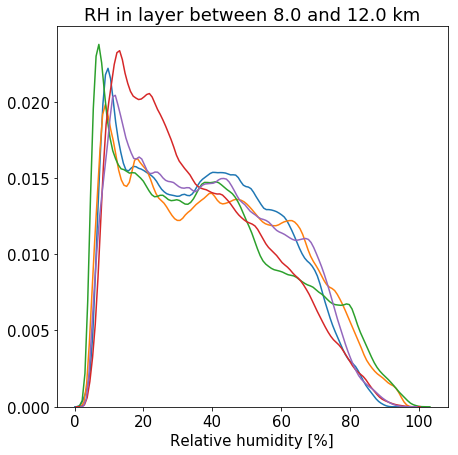

In [34]:
fig, ax = plt.subplots(figsize=(7,7))
bins = np.arange(0, 101, 5)
h = 10000
for m in models:
    ax = sns.distplot(
        tropical_level_rel_hum[m][h].data.ravel() * 1e2,
        hist=False,
        #bins=bins,
        #hist_kws={"histtype": "step", "linewidth": 3},
        kde_kws={'kernel': 'gau'}
    )
ax.set_title(f'RH in layer between {height_bnds[h][0] * 1e-3} and {height_bnds[h][-1] * 1e-3} km')
ax.set_xlabel('Relative humidity [%]')